In [1]:
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from sklearn.model_selection import train_test_split

In [2]:
vgg = VGG16()

model = Model(inputs = vgg.inputs, outputs = vgg.layers[-2].output)
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [3]:
base_direct = "archive_og"

features = {}
directory = os.path.join(base_direct, "Images")

for img_name in os.listdir(directory):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature

In [4]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [5]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [6]:
with open(os.path.join("./archive_og", 'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

all_cap = []
for key in mapping:
    for caption in mapping[key]:
        all_cap.append(caption)

max_length = max(len(caption.split()) for caption in all_cap)
max_length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8494

In [7]:
#train test split
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids, test_size=0.05, random_state = 10)

In [8]:
from tensorflow.keras.models import load_model
new_model = load_model('./best_model.keras')

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
max_length = 35
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_direct, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(new_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return y_pred

---------------------Actual---------------------
A girl with blond hair offers a dimpled smile from under her black umbrella .
A lady posing while holding an umbrella .
A young blonde woman in black smiles under her black umbrella .
Blond woman with a black shirt is holding a black umbrella over her head .
The blonde haired woman is holding a black umbrella .
--------------------Predicted--------------------
startseq tan of man dogs down is photo man children another surfer in blue hits in in in in in in in in in in in in in in in in in in in in in


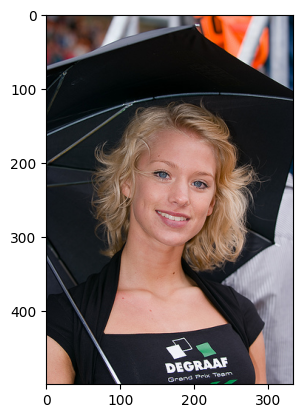

In [10]:
test1 = test[1]
caption_tested = generate_caption(test1 + ".jpg")

In [11]:
caption_words = ' '.join(caption_tested.split()[1:])
all_cap_and_test = all_cap.copy()
all_cap_and_test.append(caption_words)

all_cap_lower = [x.lower() for x in all_cap_and_test]

print(all_cap_lower[-1])

tan of man dogs down is photo man children another surfer in blue hits in in in in in in in in in in in in in in in in in in in in in


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vec = TfidfVectorizer()
X = tfid_vec.fit_transform(all_cap_lower)

In [13]:
def pick_closest_values(arr):
    mean = np.mean(arr)
    closest_values = sorted(enumerate(arr), key=lambda x: abs(x[1] - mean))[:3]
    closest_indexes = [index for index, _ in closest_values]
    return closest_indexes

In [14]:
cap_weights = X.toarray()[-1][np.nonzero(X.toarray()[-1])]
cap_vocab = tfid_vec.get_feature_names_out()[np.nonzero(X.toarray()[-1])]

top_indexes = pick_closest_values(cap_weights)
top_words = cap_vocab[top_indexes]
print(top_words)

['hits' 'photo' 'surfer']


In [15]:
from emoji_translate.emoji_translate import Translator
import emoji

emoji = Translator(exact_match_only = False, randomize = True)

caption_emoji = ""
for word in top_words:

    if word.endswith("es"):
        word = word[:-2]
    elif word.endswith("s"):
        word = word[:-1]    
    
    elif word.endswith("ed"):
        word = word[:-2]
    caption_emoji += emoji.emojify(word)

print(caption_emoji)


👊🏘surfer
